In [11]:
from CurveDataFetcher import CurveDataFetcher 
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from utils.pca import run_pca_yield_curve

import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), ".env")
print(env_path)
config = dotenv_values(env_path)

import nest_asyncio
nest_asyncio.apply()

import matplotlib.pylab as pylab
params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (20, 10),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)
sns.set(style="whitegrid", palette="dark")
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

%load_ext autoreload
%autoreload 2

c:\Users\chris\Curvy-CUSIPs\.env
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True, fred_api_key=config["FRED_API_KEY"])

In [13]:
tenors = ["CT3M", "CT6M", "CT1", "CT2", "CT3", "CT5", "CT7", "CT10", "CT20", "CT30"]
ct_yields_df = curve_data_fetcher.fedinvest_data_fetcher.get_historical_ct_yields(
    start_date=datetime(2023, 1, 1),
    end_date=datetime(2024, 9, 12),
    tenors=tenors,
    use_mid_side=True,
)
ct_yields_df = ct_yields_df.dropna()
ct_yields_df

,Date,CT3M,CT6M,CT1,CT2,CT3,CT5,CT7,CT10,CT20,CT30
0,2023-01-03,4.706192,4.803630,4.736549,4.411551,4.189280,3.930628,3.873681,3.778853,4.056092,3.883172
1,2023-01-04,4.714133,4.782165,4.717247,4.365910,4.123733,3.861012,3.797915,3.704713,3.973256,3.815392
2,2023-01-05,4.745792,4.838718,4.790574,4.449214,4.203786,3.923620,3.842750,3.733609,3.978388,3.805479
3,2023-01-06,4.804019,4.866754,4.743896,4.282585,4.018251,3.734201,3.663721,3.574217,3.857279,3.693056
4,2023-01-09,4.727578,4.816827,4.713362,4.182474,3.929881,3.639200,3.578764,3.514221,3.817643,3.658459
...,...,...,...,...,...,...,...,...,...,...,...
417,2024-09-06,5.176797,4.759565,4.139633,3.650193,3.522428,3.466263,3.559899,3.669289,4.043890,3.964290
418,2024-09-09,5.091138,4.716178,4.137625,3.666513,3.544736,3.493635,3.591507,3.710513,4.092004,4.016566
419,2024-09-10,4.994274,4.705435,4.105113,3.633188,3.496565,3.452300,3.549583,3.665418,4.046132,3.969880
420,2024-09-11,5.015769,4.734399,4.094213,3.599802,3.451204,3.417868,3.515332,3.632628,4.020476,3.948661


In [4]:
corr_df = ct_yields_df.set_index("Date").corr()
corr_df.style.background_gradient(
    sns.diverging_palette(250, 5, as_cmap=True), axis=1
).format(precision=6)

,CT3M,CT6M,CT1,CT2,CT3,CT5,CT7,CT10,CT20,CT30
CT3M,1.000000,0.934929,0.706102,0.605898,0.603536,0.629624,0.636529,0.638430,0.655736,0.638845
CT6M,0.934929,1.000000,0.883615,0.788267,0.759372,0.735535,0.708795,0.663566,0.656420,0.616061
CT1,0.706102,0.883615,1.000000,0.929258,0.867748,0.786937,0.722921,0.627152,0.586925,0.521944
CT2,0.605898,0.788267,0.929258,1.000000,0.982452,0.928587,0.873915,0.786350,0.724074,0.665721
CT3,0.603536,0.759372,0.867748,0.982452,1.000000,0.977205,0.940125,0.871998,0.814325,0.766610
CT5,0.629624,0.735535,0.786937,0.928587,0.977205,1.000000,0.990102,0.954037,0.913484,0.880255
CT7,0.636529,0.708795,0.722921,0.873915,0.940125,0.990102,1.000000,0.985206,0.958613,0.933944
CT10,0.638430,0.663566,0.627152,0.786350,0.871998,0.954037,0.985206,1.000000,0.988682,0.979368
CT20,0.655736,0.656420,0.586925,0.724074,0.814325,0.913484,0.958613,0.988682,1.000000,0.993476
CT30,0.638845,0.616061,0.521944,0.665721,0.766610,0.880255,0.933944,0.979368,0.993476,1.000000


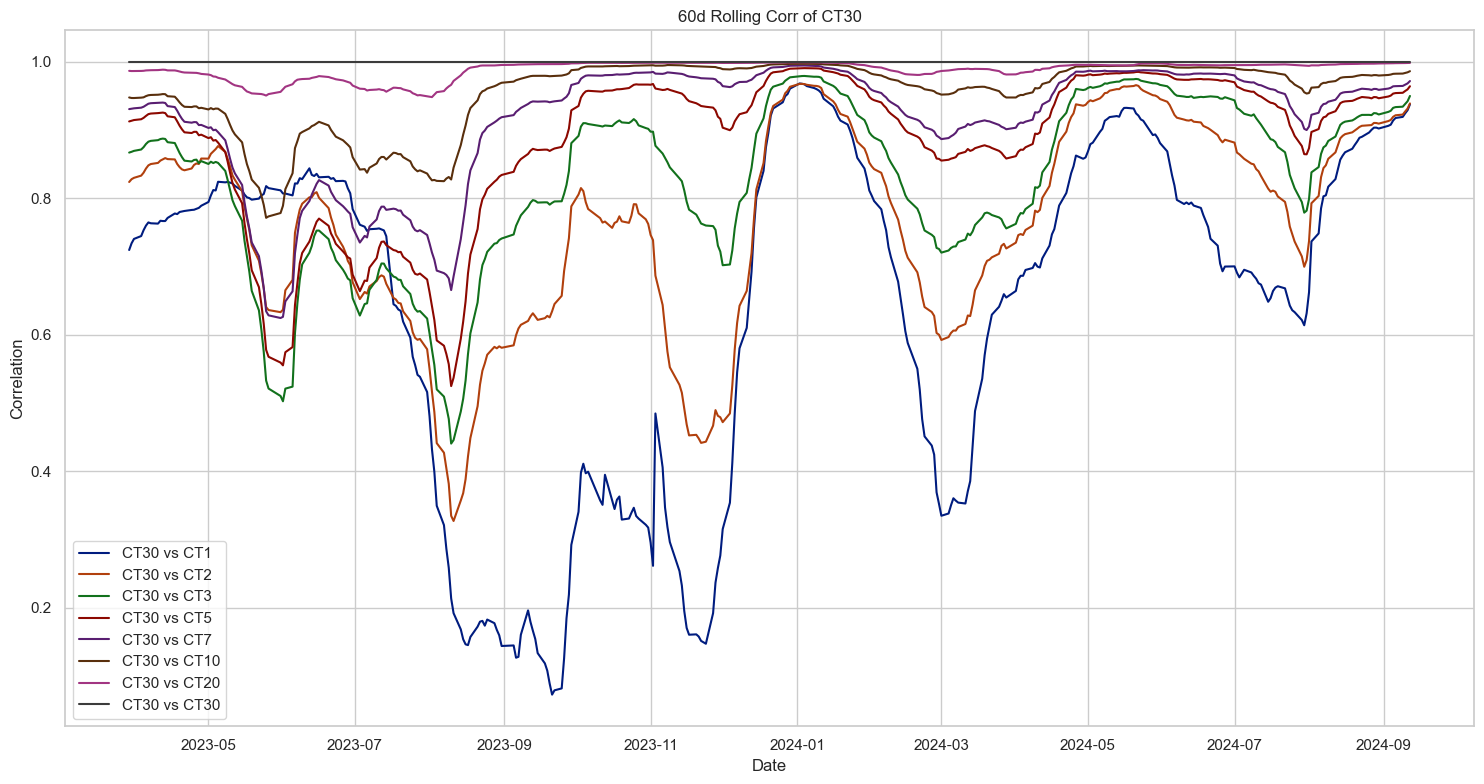

In [9]:
rolling_window = 60
plt.figure(figsize=(15, 8))
col1 = "CT30"
for j, col2 in enumerate(ct_yields_df.columns[3:]):
    rolling_corr = ct_yields_df[col1].rolling(rolling_window).corr(ct_yields_df[col2])
    plt.plot(ct_yields_df["Date"], rolling_corr, label=f'{col1} vs {col2}')

plt.title(f"{rolling_window}d Rolling Corr of {col1}")
plt.xlabel("Date")
plt.ylabel('Correlation')
plt.legend()  
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
pc3_ct_df = run_pca_yield_curve(
    df=ct_yields_df.set_index("Date"),
    n_components=3,
    # show_cum_ex_var=True,
    # show_most_recent=True,
    # show_trend=True,
    # show_recessions=True,
    show_reconstructed=True,
)
pca_n3_residuals_df = pd.DataFrame(
    ct_yields_df.set_index("Date").values - pc3_ct_df.values,
    columns=pc3_ct_df.columns,
    index=pc3_ct_df.index,
)
pca_n3_residuals_df


Reconstruction Error (MSE): 0.0008132488692310707


,CT3M,CT6M,CT1,CT2,CT3,CT5,CT7,CT10,CT20,CT30
Date,,,,,,,,,,
2023-01-03,-0.005217,-0.002310,0.012536,-0.012108,0.005286,0.002377,-0.002783,-0.017125,0.022650,-0.002693
2023-01-04,0.005508,-0.016455,0.012960,-0.006071,0.002015,0.003630,-0.002970,-0.013389,0.012687,0.001704
2023-01-05,0.007706,-0.008321,0.001310,-0.012281,0.007520,0.011933,0.001055,-0.006629,0.006446,-0.009683
2023-01-06,-0.005755,-0.002961,0.016150,-0.014077,0.003258,0.001728,-0.003457,-0.007410,0.015115,-0.001967
2023-01-09,-0.034258,0.001618,0.060067,-0.028405,-0.003807,-0.017742,-0.016967,-0.003845,0.032752,0.014631
...,...,...,...,...,...,...,...,...,...,...
2024-09-06,0.100364,-0.073316,-0.071174,0.017935,0.036951,0.027879,0.025746,0.004363,-0.026401,-0.054093
2024-09-09,0.079791,-0.067396,-0.046002,0.016760,0.027321,0.015894,0.014588,0.001763,-0.013782,-0.038115
2024-09-10,0.045795,-0.028200,-0.040927,0.014956,0.011537,0.013100,0.015592,0.004170,-0.008362,-0.033629


In [37]:
pc2_ct_df = run_pca_yield_curve(
    df=ct_yields_df.set_index("Date"),
    n_components=2,
    # show_cum_ex_var=True,
    # show_most_recent=True,
    # show_trend=True,
    # show_recessions=True,
    show_reconstructed=True,
)
pca_n2_residuals_df = pd.DataFrame(
    ct_yields_df.set_index("Date").values - pc2_ct_df.values,
    columns=pc2_ct_df.columns,
    index=pc2_ct_df.index,
)
pca_n2_residuals_df


Reconstruction Error (MSE): 0.007066439300859886


,CT3M,CT6M,CT1,CT2,CT3,CT5,CT7,CT10,CT20,CT30
Date,,,,,,,,,,
2023-01-03,-0.473964,-0.286177,-0.008926,0.184126,0.205979,0.137541,0.081325,-0.010511,-0.055789,-0.108754
2023-01-04,-0.438918,-0.285594,-0.007389,0.179982,0.192295,0.131782,0.076774,-0.007117,-0.061682,-0.098854
2023-01-05,-0.451170,-0.286211,-0.019701,0.179821,0.203987,0.144250,0.083392,-0.000153,-0.070342,-0.113511
2023-01-06,-0.326478,-0.197187,0.001465,0.120189,0.140576,0.094209,0.054091,-0.002884,-0.038554,-0.074536
2023-01-09,-0.354619,-0.192389,0.045399,0.105710,0.133355,0.074635,0.040516,0.000676,-0.020856,-0.057855
...,...,...,...,...,...,...,...,...,...,...
2024-09-06,0.270953,0.029991,-0.063363,-0.053480,-0.036087,-0.021311,-0.004863,0.001956,0.002146,-0.015494
2024-09-09,0.186558,-0.002739,-0.041113,-0.027936,-0.018391,-0.014892,-0.004569,0.000256,0.004085,-0.013957
2024-09-10,0.116953,0.014892,-0.037669,-0.014833,-0.018929,-0.007419,0.002823,0.003166,0.003545,-0.017529


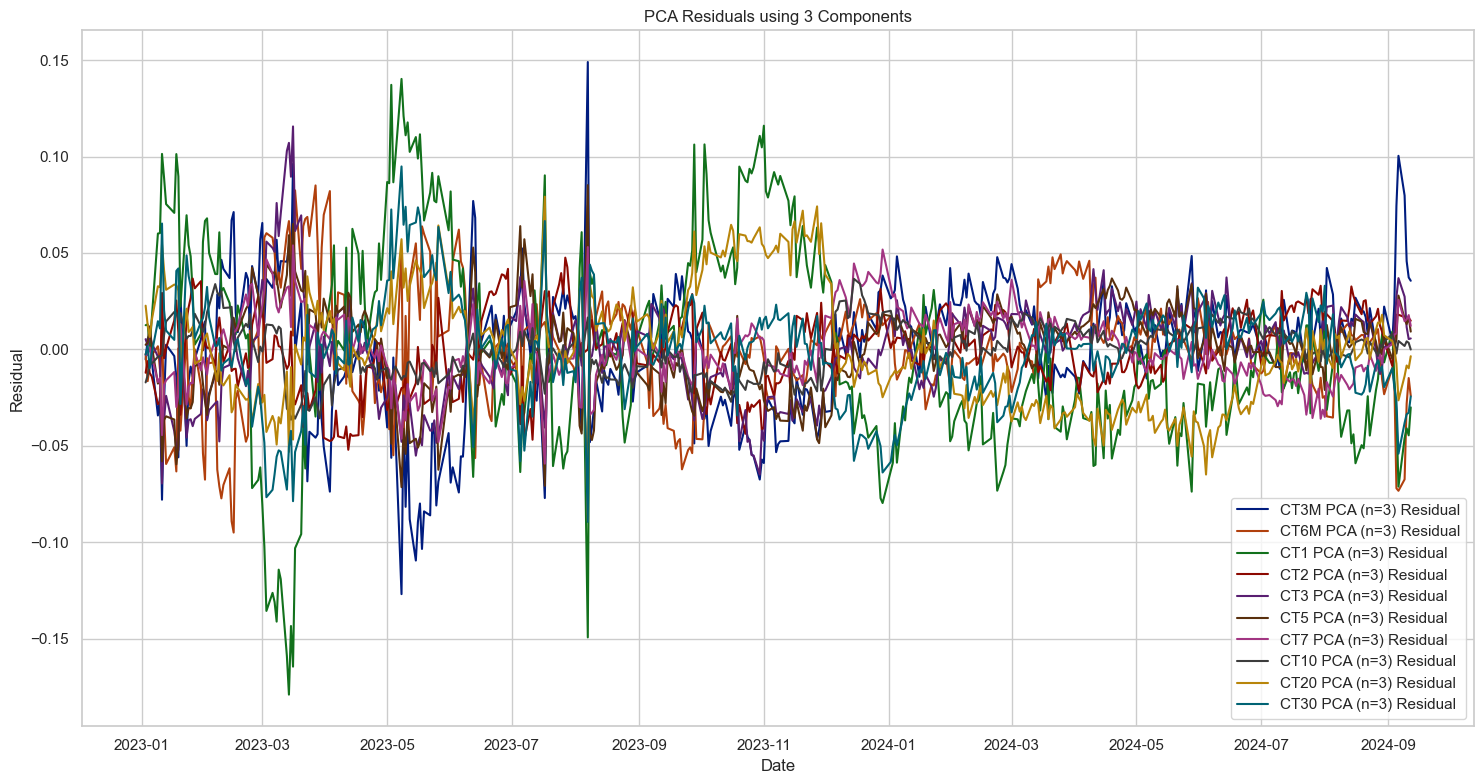

In [38]:
plt.figure(figsize=(15, 8))

for col in pca_n3_residuals_df.columns:
    plt.plot(pca_n3_residuals_df.index, pca_n3_residuals_df[col], label=f"{col} PCA (n=3) Residual")

plt.title("PCA Residuals using 3 Components")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

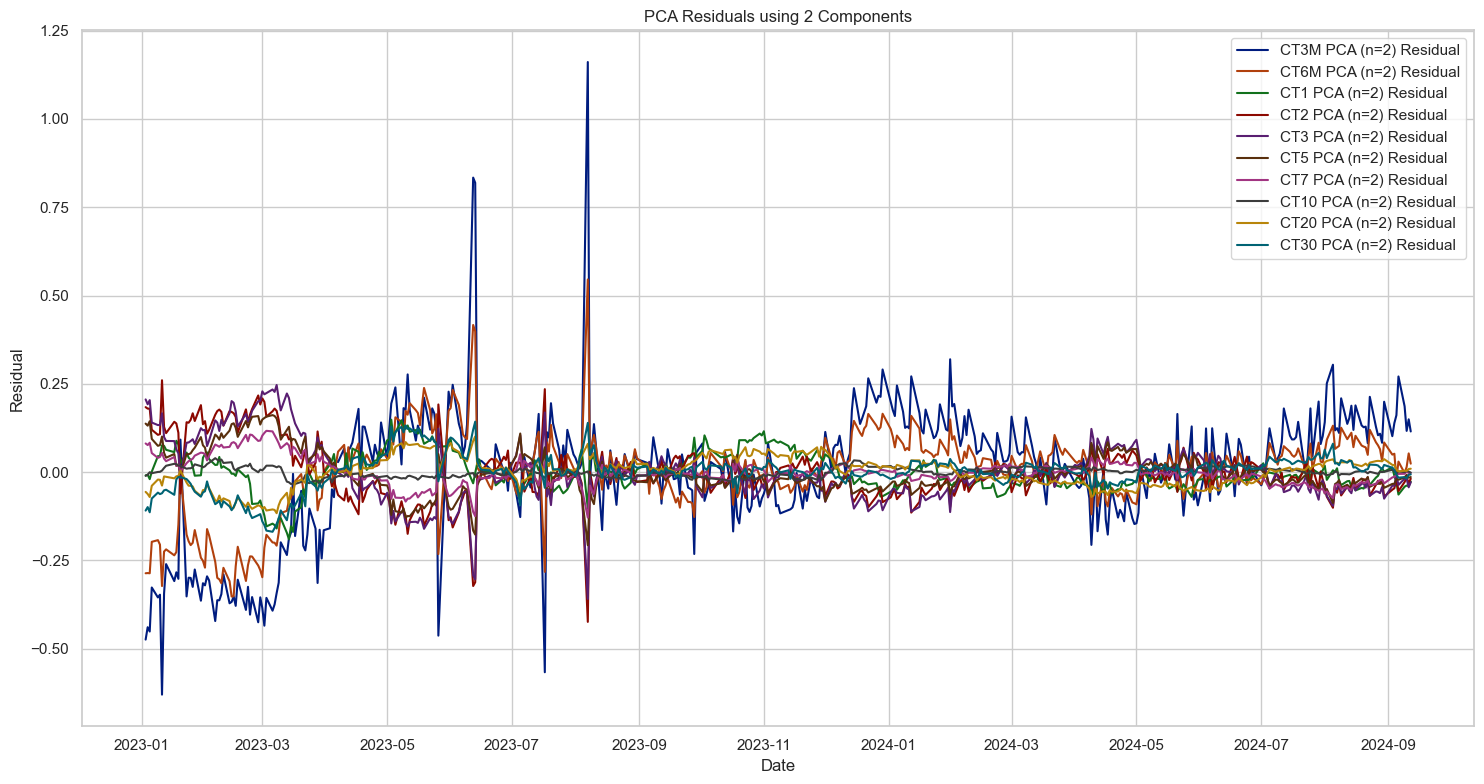

In [39]:
plt.figure(figsize=(15, 8))

for col in pca_n2_residuals_df.columns:
    plt.plot(pca_n2_residuals_df.index, pca_n2_residuals_df[col], label=f"{col} PCA (n=2) Residual")

plt.title("PCA Residuals using 2 Components")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

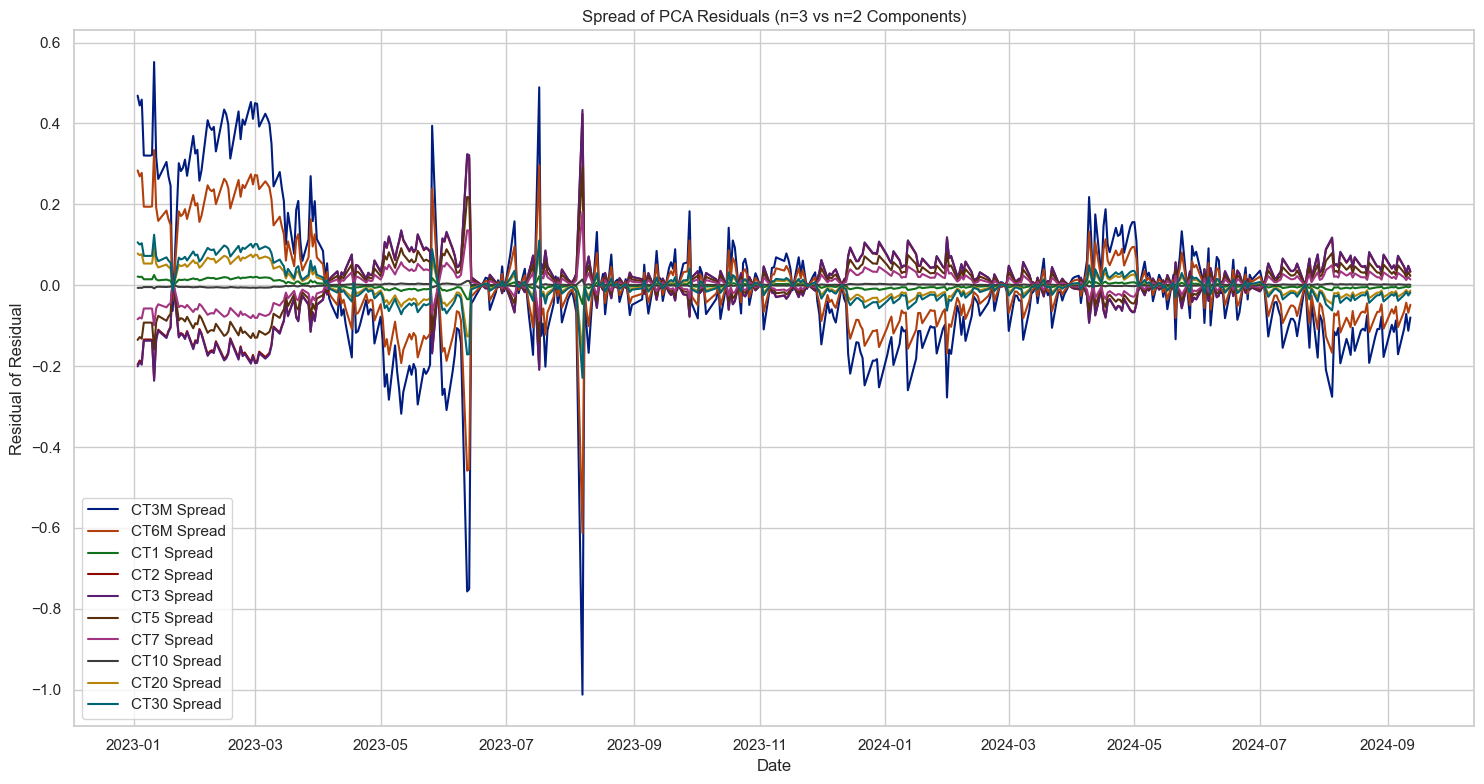

In [41]:
pca_residual_spread_df = pd.DataFrame(
    pca_n3_residuals_df.values - pca_n2_residuals_df.values,
    columns=pc2_ct_df.columns,
    index=pc2_ct_df.index,
)

plt.figure(figsize=(15, 8))

for col in pca_residual_spread_df.columns:
    plt.plot(pca_residual_spread_df.index, pca_residual_spread_df[col], label=f"{col} Spread")

plt.title("Spread of PCA Residuals (n=3 vs n=2 Components)")
plt.xlabel("Date")
plt.ylabel("Residual of Residual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
srf_dict_df = curve_data_fetcher.wsj_data_fetcher.wsj_timeseries_api(
    wsj_ticker_keys=[
        "FUTURE/US/XCME/SR3CU24",
        "FUTURE/US/XCME/SR3CZ24",
        "FUTURE/US/XCME/SR3CH25",
        "FUTURE/US/XCME/SR3CM25",
        "FUTURE/US/XCME/SR3CU25",
        "FUTURE/US/XCME/SR3CZ25",
        "FUTURE/US/XCME/SR3CH26",
        "FUTURE/US/XCME/SR3CM26",
        "FUTURE/US/XCME/SR3CU26",
        "FUTURE/US/XCME/SR3CZ26",
        "FUTURE/US/XCME/SR3CH27",
        "FUTURE/US/XCME/SR3CM27",
        "FUTURE/US/XCME/SR3CU27",
        "FUTURE/US/XCME/SR3CZ27",
        "FUTURE/US/XCME/SR3CH28",
        "FUTURE/US/XCME/SR3CM28",
        "FUTURE/US/XCME/SR3CU28",
        "FUTURE/US/XCME/SR3CZ28",
    ]
)

srf_df = reduce(
    lambda left, right: pd.merge(left, right, on="Date", how="outer"),
    srf_dict_df.values(),
)
srf_df.columns = [col_str.split("/")[-1] for col_str in srf_df.columns]
srf_df = srf_df[srf_df["Date"] > datetime(2024, 1, 1)]

srf_df

,Date,SR3CU24,SR3CZ24,SR3CH25,SR3CM25,SR3CU25,SR3CZ25,SR3CH26,SR3CM26,SR3CU26,SR3CZ26,SR3CH27,SR3CM27,SR3CU27,SR3CZ27,SR3CH28,SR3CM28,SR3CU28,SR3CZ28
1063,2024-01-02,95.8250,96.175,96.470,96.675,96.780,96.815,96.810,96.795,96.780,96.765,96.750,96.725,96.695,96.665,96.635,96.590,96.540,96.500
1064,2024-01-03,95.7950,96.165,96.475,96.695,96.810,96.850,96.845,96.830,96.815,96.805,96.785,96.760,96.735,96.705,96.670,96.630,96.585,96.545
1065,2024-01-04,95.7300,96.080,96.375,96.580,96.695,96.735,96.730,96.715,96.705,96.695,96.675,96.650,96.630,96.600,96.570,96.530,96.485,96.445
1066,2024-01-05,95.7250,96.065,96.355,96.555,96.665,96.700,96.695,96.680,96.665,96.650,96.630,96.605,96.580,96.550,96.515,96.475,96.435,96.395
1067,2024-01-08,95.7500,96.100,96.390,96.590,96.700,96.735,96.725,96.705,96.685,96.670,96.650,96.625,96.595,96.565,96.530,96.490,96.445,96.405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,2024-09-09,95.1050,95.910,96.545,96.885,97.050,97.130,97.165,97.165,97.145,97.120,97.090,97.060,97.030,96.995,96.965,96.930,96.890,96.850
1236,2024-09-10,95.1125,95.940,96.595,96.950,97.120,97.200,97.230,97.230,97.205,97.175,97.150,97.120,97.090,97.055,97.025,96.990,96.950,96.910
1237,2024-09-11,95.0525,95.850,96.525,96.905,97.085,97.170,97.205,97.210,97.195,97.170,97.145,97.115,97.085,97.055,97.020,96.985,96.950,96.910
1238,2024-09-12,95.0925,95.885,96.535,96.895,97.070,97.145,97.180,97.185,97.165,97.140,97.110,97.080,97.050,97.020,96.985,96.950,96.915,96.875


In [39]:
corr_df = srf_df.set_index("Date").corr()
corr_df.style.background_gradient(
    sns.diverging_palette(250, 5, as_cmap=True), axis=1
).format(precision=6)

,SR3CU24,SR3CZ24,SR3CH25,SR3CM25,SR3CU25,SR3CZ25,SR3CH26,SR3CM26,SR3CU26,SR3CZ26,SR3CH27,SR3CM27,SR3CU27,SR3CZ27,SR3CH28,SR3CM28,SR3CU28,SR3CZ28
SR3CU24,1.000000,0.898503,0.780016,0.720410,0.680911,0.635424,0.578487,0.524220,0.486345,0.458563,0.429852,0.397805,0.371305,0.347082,0.326502,0.299158,0.276330,0.266490
SR3CZ24,0.898503,1.000000,0.974987,0.949822,0.929717,0.904319,0.869932,0.834549,0.807885,0.787318,0.765890,0.741647,0.721034,0.701795,0.685356,0.663708,0.645292,0.637252
SR3CH25,0.780016,0.974987,1.000000,0.995242,0.987139,0.974294,0.954320,0.931423,0.912650,0.897488,0.881540,0.863109,0.847138,0.831936,0.818831,0.801621,0.786685,0.780057
SR3CM25,0.720410,0.949822,0.995242,1.000000,0.997918,0.991283,0.978243,0.961323,0.946449,0.934014,0.920764,0.905124,0.891445,0.878263,0.866827,0.851747,0.838488,0.832482
SR3CU25,0.680911,0.929717,0.987139,0.997918,1.000000,0.997666,0.989333,0.976450,0.964292,0.953788,0.942387,0.928679,0.916569,0.904811,0.894598,0.881029,0.868980,0.863408
SR3CZ25,0.635424,0.904319,0.974294,0.991283,0.997666,1.000000,0.996907,0.988648,0.979660,0.971425,0.962175,0.950744,0.940484,0.930383,0.921553,0.909707,0.899061,0.894002
SR3CH26,0.578487,0.869932,0.954320,0.978243,0.989333,0.996907,1.000000,0.997353,0.992262,0.986825,0.980248,0.971654,0.963648,0.955564,0.948343,0.938542,0.929559,0.925102
SR3CM26,0.524220,0.834549,0.931423,0.961323,0.976450,0.988648,0.997353,1.000000,0.998633,0.995888,0.991869,0.986021,0.980184,0.974015,0.968290,0.960395,0.952975,0.949102
SR3CU26,0.486345,0.807885,0.912650,0.946449,0.964292,0.979660,0.992262,0.998633,1.000000,0.999239,0.997089,0.993243,0.988991,0.984224,0.979595,0.973070,0.966777,0.963334
SR3CZ26,0.458563,0.787318,0.897488,0.934014,0.953788,0.971425,0.986825,0.995888,0.999239,1.000000,0.999271,0.996933,0.993877,0.990186,0.986404,0.980900,0.975446,0.972331


In [43]:
l = [1, 2]
l[1:]

[2]